In [2]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
import torch
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import pandas as pd
import lightning as L
import pytorch_lightning as pl




In [3]:
for dir_name,_, file_names in os.walk('F:\pycham\PycharmProjects\pythonProject\RNN\Archive'):
    for file_name in file_names:
        paths = os.path.join(dir_name, file_name)
        

In [4]:
path = r'F:\pycham\PycharmProjects\pythonProject\RNN\Archive'
files = Path(path).glob('*.csv')
df = pd.concat((pd.read_csv(f) for f in files), ignore_index=True)

In [5]:
df.head()


,Unnamed: 0,TxnDate,TxnTime,Consumption
0,76229,01 Jan 2022,16:55:52,1.010
1,76258,01 Jan 2022,21:45:29,0.908
2,76287,01 Jan 2022,12:24:52,0.926
3,76316,01 Jan 2022,04:07:36,0.928
4,76345,01 Jan 2022,06:52:25,0.916


In [6]:
df = df.drop(['Unnamed: 0'], axis=1)


In [7]:
df.head()

,TxnDate,TxnTime,Consumption
0,01 Jan 2022,16:55:52,1.010
1,01 Jan 2022,21:45:29,0.908
2,01 Jan 2022,12:24:52,0.926
3,01 Jan 2022,04:07:36,0.928
4,01 Jan 2022,06:52:25,0.916


In [8]:
df['Timestamp'] = pd.to_datetime(df['TxnDate'] + ' ' + df['TxnTime'])
df = df.sort_values('Timestamp')
df.drop(['TxnDate', 'TxnTime'], axis=1, inplace=True)
df

,Consumption,Timestamp
43,1.030,2022-01-01 00:22:28
19,0.904,2022-01-01 00:42:33
25,0.904,2022-01-01 01:01:51
11,1.850,2022-01-01 01:41:48
29,1.878,2022-01-01 02:22:52
...,...,...
3553,1.152,2022-02-28 22:25:43
3568,0.888,2022-02-28 22:44:37
3542,1.064,2022-02-28 23:07:15
3583,1.036,2022-02-28 23:29:13


In [9]:
df.head()
print(f"min date: {df['Timestamp'].min()}, max date: {df['Timestamp'].max()}")
print(f"range: {df['Timestamp'].max()-df['Timestamp'].min()}")

df.describe()

min date: 2022-01-01 00:22:28, max date: 2022-02-28 23:50:27
range: 58 days 23:27:59


,Consumption,Timestamp
count,3606.000000,3606
mean,2.781508,2022-01-30 12:02:06.618691072
min,0.000000,2022-01-01 00:22:28
25%,0.948000,2022-01-15 11:04:40.249999872
50%,1.032000,2022-01-31 03:55:32.500000
75%,4.005500,2022-02-14 05:26:33.249999872
max,27.284000,2022-02-28 23:50:27
std,2.961248,NaN


In [10]:
df.sort_values('Timestamp').rolling('1D',on='Timestamp').sum().head()



,Consumption,Timestamp
43,1.030,2022-01-01 00:22:28
19,1.934,2022-01-01 00:42:33
25,2.838,2022-01-01 01:01:51
11,4.688,2022-01-01 01:41:48
29,6.566,2022-01-01 02:22:52


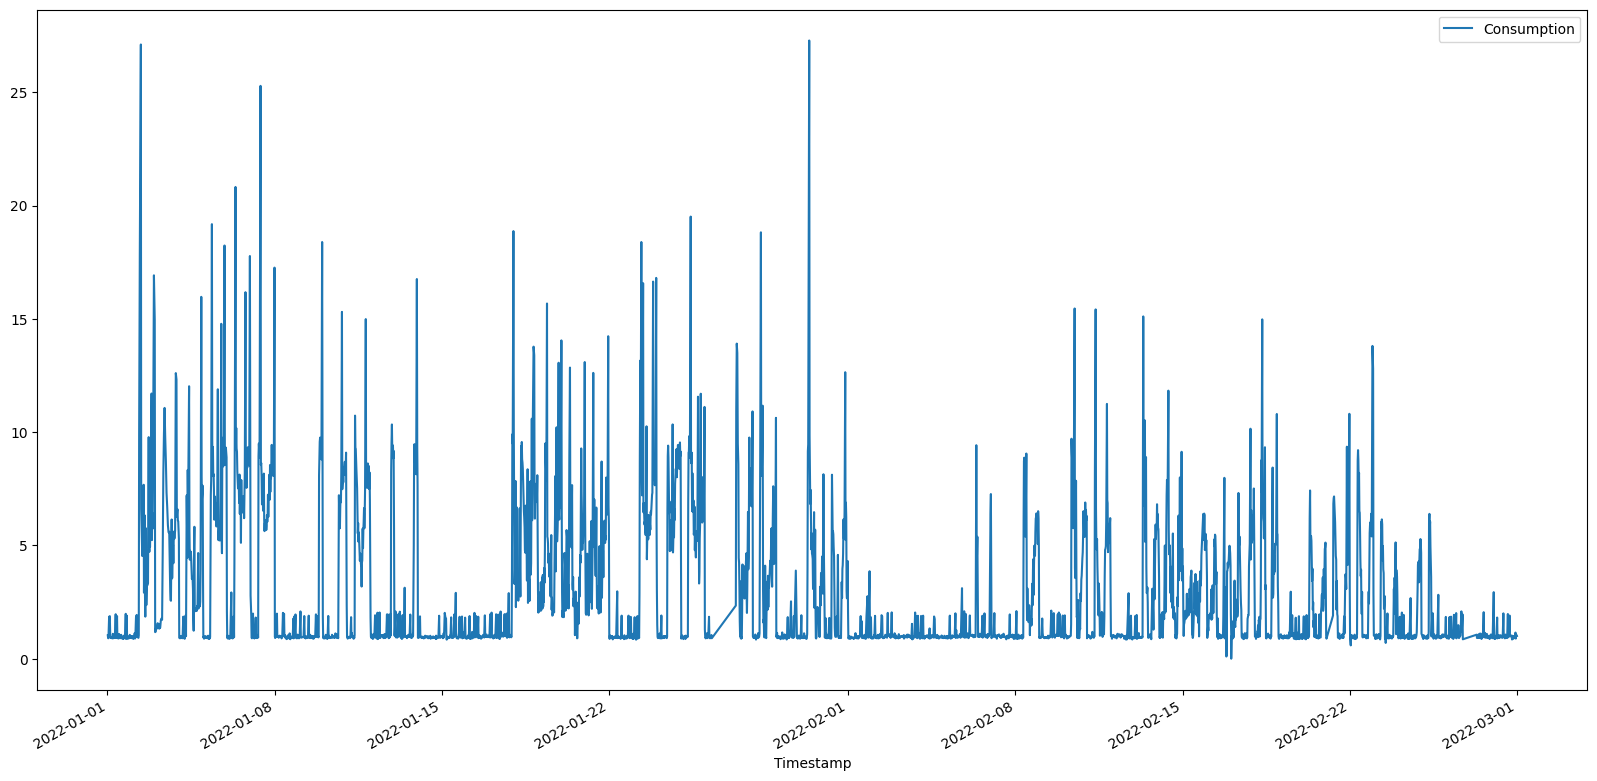

In [11]:
#    draw pylot to show data follow weekly
df.plot(x='Timestamp', y='Consumption', figsize=(20,10))
plt.show()

In [12]:
df_copy = df.set_index('Timestamp').sort_index()
df_copy = df_copy.resample('1B').sum()

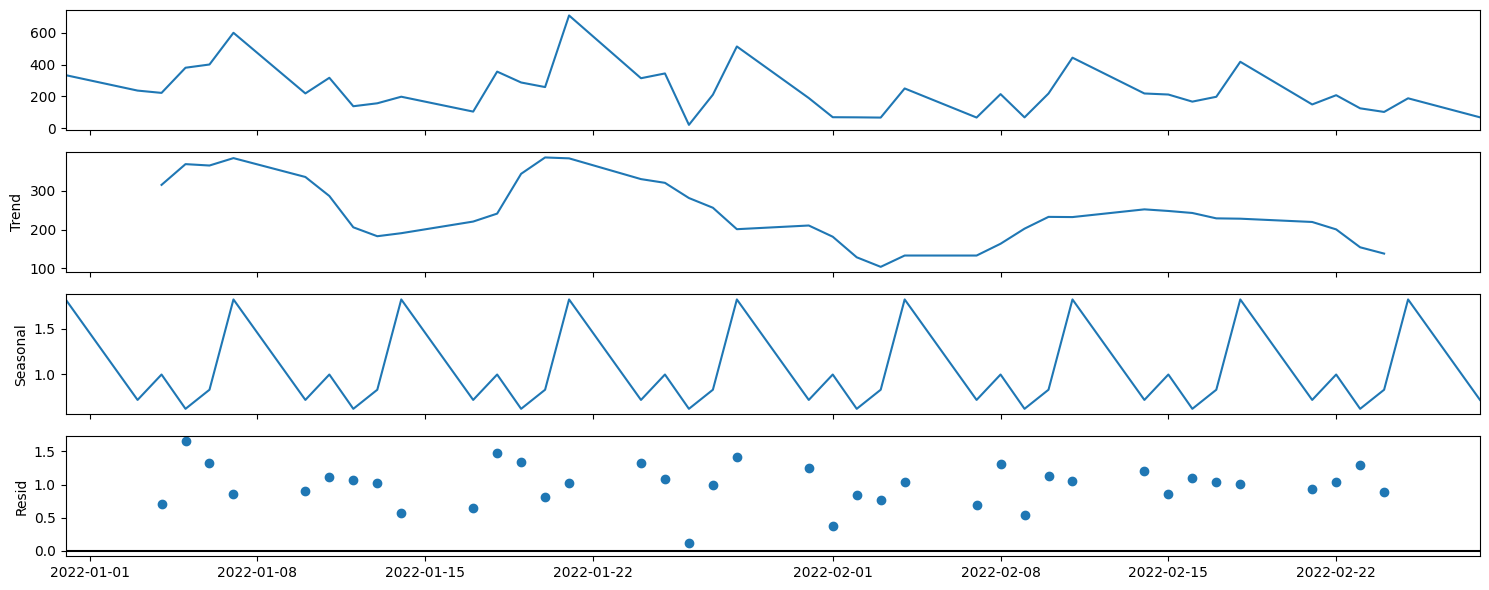

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df_copy,model='multiplicative')
plt.rc("figure", figsize=(15,6))
result.plot()
plt.show()

In [14]:
#   Nomalize Consumption to 0-1
df_copy['Consumption'] = df_copy['Consumption']/df_copy['Consumption'].max()
df_copy.head()

,Consumption
Timestamp,
2021-12-31,0.470280
2022-01-03,0.333178
2022-01-04,0.312692
2022-01-05,0.536077
2022-01-06,0.564716


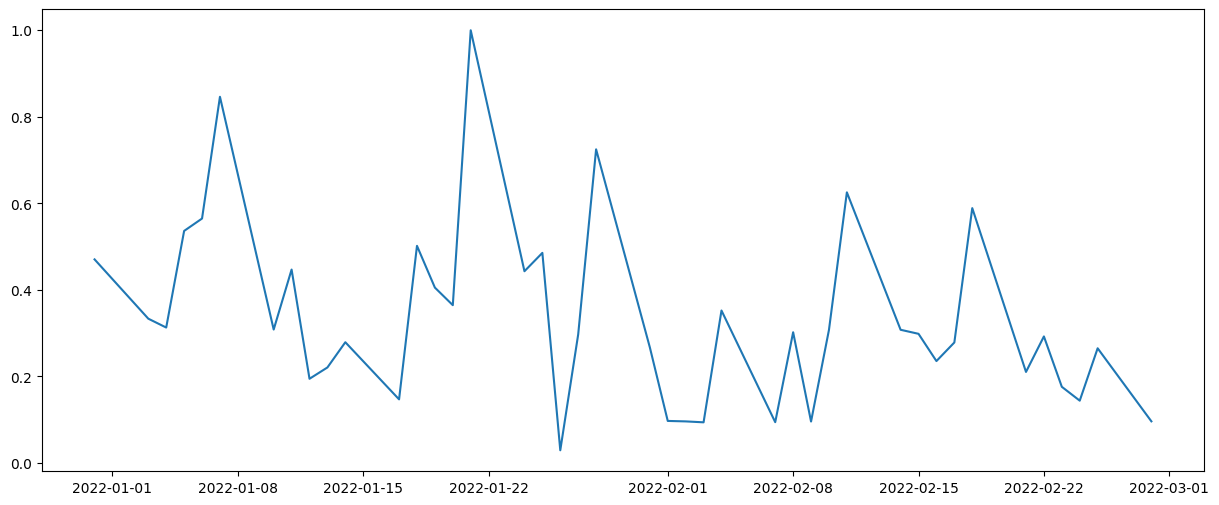

In [15]:
plt.plot(df_copy)
plt.show()

In [16]:
class LSTM(nn.Module):
    def __init__(self):
        super().__init__()

        mean = torch.tensor(0.0)
        std = torch.tensor(1.0)
        self.wlr1 = nn.Parameter(torch.normal(mean = mean, std=std), requires_grad=True)
        self.wlr2 = nn.Parameter(torch.normal(mean = mean, std=std), requires_grad=True)
        self.blr1 = nn.Parameter(torch.tensor(0.), requires_grad=True)

        self.wpr1 = nn.Parameter(torch.normal(mean = mean, std=std), requires_grad=True)
        self.wpr2 = nn.Parameter(torch.normal(mean = mean, std=std), requires_grad=True)
        self.bpr1 = nn.Parameter(torch.tensor(0.), requires_grad=True)

        self.wp1 = nn.Parameter(torch.normal(mean = mean, std=std), requires_grad=True)
        self.wp2 = nn.Parameter(torch.normal(mean = mean, std=std), requires_grad=True)
        self.bp1 = nn.Parameter(torch.tensor(0.), requires_grad=True)

        self.wo1 = nn.Parameter(torch.normal(mean = mean, std=std), requires_grad=True)
        self.wo2 = nn.Parameter(torch.normal(mean = mean, std=std), requires_grad=True)
        self.bo1 = nn.Parameter(torch.tensor(0.), requires_grad=True)
    def lstm_unit(self, input_value, long_memory, short_memory):
        long_remember_percent = torch.sigmoid((self.wlr1 * short_memory) +
                                               (self.wlr2 * input_value) +
                                                self.blr1)
        potential_remember_percent = torch.sigmoid((self.wpr1 * short_memory) +
                                                  (self.wpr2 * input_value) +
                                                    self.bpr1)
        potential_memory = torch.tanh((self.wp1 * short_memory) +
                                        (self.wp2 * input_value) +
                                        self.bp1)
        updated_long_memory = (long_memory * long_remember_percent) + (potential_memory * potential_remember_percent)
        output_percent = torch.sigmoid((self.wo1 * short_memory) +
                                        (self.wo2 * input_value) +
                                        self.bo1)
        updated_short_memory = torch.tanh(updated_long_memory) * output_percent
        return updated_long_memory, updated_short_memory
        
    def forward(self, input):
        long_memory = torch.tensor(0.)
        short_memory = torch.tensor(0.)
        for i in range(input.shape[0]):
            long_memory, short_memory = self.lstm_unit(input[i], long_memory, short_memory)
        return short_memory
    
    def configure_optimizers(self):
        return Adam(self.parameters(), lr=1e-3)
    
    def training_step(self, batch, batch_idx):
        input_i, lable_i = batch
        output_i = self.forward(input_i[0])
        loss = F.mse_loss(output_i, lable_i)
        self.log('train_loss', loss)

        if (lable_i == 0):
            self.log("out_0", output_i)
        else:
            self.log("out_1", output_i)
        return loss    
model = LSTM()
model.train()

LSTM()

In [17]:
df_copy.describe()

,Consumption
count,42.000000
mean,0.336342
std,0.210425
min,0.028917
25%,0.198194
50%,0.299999
75%,0.445787
max,1.000000


C:\Users\Administrator\AppData\Local\Temp\ipykernel_3824\1197402886.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:204.)
  train_data = torch.tensor([train_data.values], dtype=torch.float32)
e:\Programdata\minoconda\envs\tensorflow\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([1, 7])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0: 0.07094382494688034
Epoch 100: 0.043809253722429276
Epoch 200: 0.024813687428832054
Epoch 300: 0.022707009688019753
Epoch 400: 0.02270534820854664
Epoch 500: 0.022705350071191788
Epoch 600: 0.02270534820854664
Epoch 700: 0.022705350071191788
Epoch 800: 0.022705350071191788
Epoch 900: 0.022705350071191788
Epoch 1000: 0.022705350071191788
Epoch 1100: 0.022705350071191788
Epoch 1200: 0.022705350071191788
Epoch 1300: 0.022705350071191788
Epoch 1400: 0.022705350071191788
Epoch 1500: 0.022705350071191788
Epoch 1600: 0.022705350071191788
Epoch 1700: 0.022705350071191788
Epoch 1800: 0.022705350071191788
Epoch 1900: 0.022705350071191788


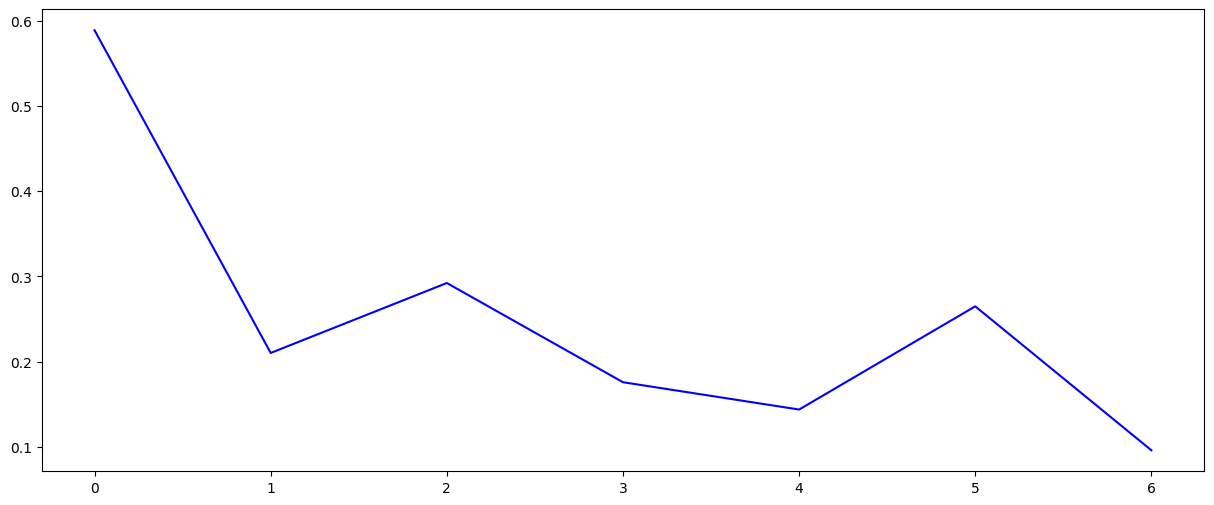

In [18]:
model = LSTM()
train_data = df_copy["Consumption"].iloc[:35]  
test_data = df_copy["Consumption"].iloc[35:]

loss_fn = nn.MSELoss()
optimizer = Adam(model.parameters())


train_data = torch.tensor([train_data.values], dtype=torch.float32)
test_data = torch.tensor([test_data.values], dtype=torch.float32)
dataset = TensorDataset(train_data, test_data)
loader = DataLoader(dataset)
n_epochs = 2000
model.train()

for epoch in range(n_epochs):
    for batch in loader:
        optimizer.zero_grad()
        input_i, lable_i = batch
        output_i = model(input_i[0])
        loss = loss_fn(output_i, lable_i)
        loss.backward()
        optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: {loss}")

# plot predict
model.eval()
with torch.no_grad():
    prediction = model(torch.tensor(df_copy["Consumption"].iloc[:35])).detach()
    plt.plot(prediction, color='red')
    plt.plot(test_data[0], color='blue')
    plt.show()


Epoch 0: train RMSE 0.4524, test RMSE 0.3421
Epoch 100: train RMSE 0.2306, test RMSE 0.1579
Epoch 200: train RMSE 0.2287, test RMSE 0.1595
Epoch 300: train RMSE 0.2283, test RMSE 0.1538
Epoch 400: train RMSE 0.2274, test RMSE 0.1573
Epoch 500: train RMSE 0.2264, test RMSE 0.1584
Epoch 600: train RMSE 0.2252, test RMSE 0.1564
Epoch 700: train RMSE 0.2225, test RMSE 0.1602
Epoch 800: train RMSE 0.2181, test RMSE 0.1582
Epoch 900: train RMSE 0.2143, test RMSE 0.1697
Epoch 1000: train RMSE 0.2094, test RMSE 0.1670
Epoch 1100: train RMSE 0.2065, test RMSE 0.1736
Epoch 1200: train RMSE 0.2039, test RMSE 0.1679
Epoch 1300: train RMSE 0.1988, test RMSE 0.1809
Epoch 1400: train RMSE 0.1918, test RMSE 0.1783
Epoch 1500: train RMSE 0.1847, test RMSE 0.1664
Epoch 1600: train RMSE 0.1795, test RMSE 0.1649


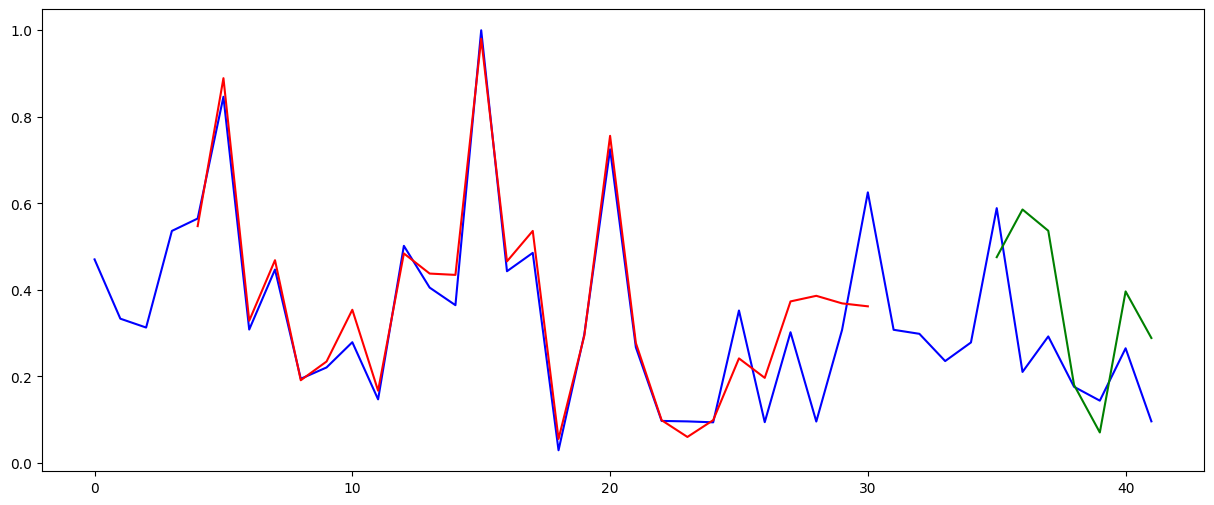

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data


timeseries = df_copy[["Consumption"]].values.astype('float32')

# train-test split for time series
train_size = int(len(timeseries) * 0.75)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

lookback = 4
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

class LSTM2(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

model = LSTM2()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=18)

n_epochs = 1700
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]
# plot
plt.plot(timeseries, c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()